In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.dates as mdates
import matplotlib.colors

from pysolar.solar import *
import pytz
import shap
import pickle


# Perameters


In [3]:
cheap_node_id = '001e06305a6b'
node_id = '10004098'
gps_node_id = '001e0610c2e9'
dir_out = '../figures/'
dir_data = '../data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

## Read Data

In [4]:
# if data has been preprocessed before, run this directly
fn_in = '../Minolta/'+node_id+'.csv' # resampled
df_minolta = pd.read_csv(fn_in, parse_dates=True, index_col = 'UTC')


In [126]:
# remove driving dates
# drive outside on Jan 8,9,10
df_minolta = df_minolta[(df_minolta.index.date > datetime.date(2020, 1, 10)) + (df_minolta.index.date < datetime.date(2020, 1, 8))]


In [108]:
# color map of spectrum
import matplotlib.colors
from wavelength_to_rgb import wavelength_to_rgb

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)


## Daily Whole Spectrum

In [89]:
# daily mean spectrum
years = [2019,2020]
months = [1, 12]

hour_start_local = 6
hour_end_local = 18

hour_jetlag = 6
jetlag = datetime.timedelta(hours=hour_jetlag)

for year in years:
    for month in months:
        for day in range(1,31+1):
            datetime_start = (datetime.datetime(year, month, day, hour_start_local, 0, 0) + jetlag)
            datetime_end   = (datetime.datetime(year, month, day, hour_end_local,   0, 0) + jetlag)
            iwant = df_minolta.index > datetime_start
            iwant*= df_minolta.index < datetime_end
            df_iwant = df_minolta[iwant].copy()
            if len(df_iwant)==0:
                continue
            print(year, month, day)
            
            x = (df_iwant.index - jetlag)# local time #.hour.values[:]
            y = np.arange(360, 780+1, 1) # wave length
            xx, yy = np.meshgrid(x, y, sparse=True)
            z = np.transpose(df_iwant.iloc[:,1:-1].values)

            if np.shape(z)[1] == 0:
                continue
            
            fig, ax = plt.subplots(constrained_layout=True, figsize=(20, 10))
            h = ax.contourf(x,y,z,levels=20, cmap="RdBu_r")
            
            ax.set_title('Full Spectrum: %02d/%02d/%02d' % (year,month,day), fontsize=40)
            ax.set_xlabel('Time',fontsize=30)
            ax.set_ylabel('Wavelength / nm',fontsize=30)
            fig.colorbar(h, ax=ax)
            
            locator = mdates.HourLocator(interval = 1)
            h_fmt = mdates.DateFormatter('%H:%M')
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(h_fmt)
            fig.autofmt_xdate()
            fig.savefig(dir_out+'Whole_Spectrum_%02d_%02d_%02d.png' % (year, month, day))
            plt.close()
            
            
            ##########################3
#             df_mean = df_iwant.iloc[:,1:-1]
#             df_mean = df_mean.fillna(0)
#             df_mean = df_mean.mean()
            
#             fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
#             wavelengths = y
#             spectrum = df_mean.values
#             h = ax.plot(wavelengths, spectrum)
            
#             plt.plot(wavelengths, spectrum)

#             y = np.linspace(0, np.max(spectrum)*1.1, 100)
#             X,Y = np.meshgrid(wavelengths, y)
#             X[X<400] = 400
#             extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

#             plt.imshow(X, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
#             plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
#             ax.set_title('Daily Mean Spectrum: %02d/%02d/%02d' % (year,month,day), fontsize=40)
#             ax.set_xlabel('Wavelength / nm',fontsize=30)
#             ax.set_ylabel('Average Intensity',fontsize=30)
            
#             fig.savefig(dir_out+'Mean_Spectrum_%02d_%02d_%02d.png' % (year, month, day))
#             plt.close()
            


2019 12 10
2019 12 25
2019 12 26
2019 12 27
2019 12 28
2019 12 29
2019 12 30
2019 12 31
2020 1 1
2020 1 2
2020 1 13
2020 1 14
2020 1 15
2020 1 16
2020 1 17
2020 1 23
2020 1 24
2020 1 25
2020 1 26
2020 1 27
2020 1 28
2020 1 29
2020 1 30
2020 1 31


## Plot Zenith Angle

In [92]:
# wavelength and solar zenith angle
years = [2019,2020]
months = [1, 12]

hour_start_local = 6
hour_end_local = 18

hour_jetlag = 6
jetlag = datetime.timedelta(hours=hour_jetlag)

for year in years:
    for month in months:
        for day in range(1,31+1):
            datetime_start = (datetime.datetime(year, month, day, hour_start_local, 0, 0) + jetlag)
            datetime_end   = (datetime.datetime(year, month, day, hour_end_local,   0, 0) + jetlag)
            iwant = df_minolta.index > datetime_start
            iwant*= df_minolta.index < datetime_end
            df_iwant = df_minolta[iwant].copy()
            if len(df_iwant)==0:
                continue
            print(year, month, day)

            x = np.array([])
            y = np.array([])
            z = np.array([])
            for i in np.arange(360, 780+1, 1):
                x = np.append(x, i*np.ones(len(df_iwant)))
                y = np.append(y, df_iwant['Zenith'].values)
                var = str(i)+'nm'
                z = np.append(z, df_iwant[var].values)

            fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 6))
            h = ax.scatter(x, y, c = z, s = 0.2, cmap="gist_rainbow_r")

            ax.set_title('Zenith Spectrum', fontsize=25)
            ax.set_xlabel('Wavelength / nm',fontsize=20)
            ax.set_ylabel('Solar Zenith Angle',fontsize=20)
            ax.set_ylim(None,90)
            fig.colorbar(h, ax=ax)

            fig.savefig(dir_out+'Zenith_Spectrum_%02d_%02d_%02d.png' % (year, month, day))
            plt.close()

2019 12 10
2019 12 25
2019 12 26
2019 12 27
2019 12 28
2019 12 29
2019 12 30
2019 12 31
2020 1 1
2020 1 2
2020 1 13
2020 1 14
2020 1 15
2020 1 16
2020 1 17
2020 1 23
2020 1 24
2020 1 25
2020 1 26
2020 1 27
2020 1 28
2020 1 29
2020 1 30
2020 1 31


## Import Features From Cheap Sensors

In [122]:
dir_in_cheap = '../lightsensors/'
fn_in_cheap = dir_in_cheap + 'MINTS_' + cheap_node_id + '.csv'

df_cheap = pd.read_csv(fn_in_cheap, parse_dates=True, index_col = 'UTC')
df_cheap.head()

,cloudPecentage,allRed,allGreen,allBlue,skyRed,skyGreen,skyBlue,cloudRed,cloudGreen,cloudBlue,...,Luminosity,IR,Full,Visible,Lux,UVA,UVB,Visible Compensation,IR Compensation,UV Index
UTC,,,,,,,,,,,,,,,,,,,,,
2019-12-01 00:00:00,79.800456,1.169759,5.495283,0.101702,2.450309,5.228208,0.283548,0.845619,5.562887,0.055673,...,262156.0,4.0,12.0,8.0,0.290133,0.0,0.0,0.0,0.0,0.0
2019-12-01 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262156.0,4.0,12.0,8.0,0.290133,0.0,0.0,0.0,0.0,0.0
2019-12-01 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262156.0,4.0,12.0,8.0,0.290133,0.0,0.0,0.0,0.0,0.0
2019-12-01 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262156.0,4.0,12.0,8.0,0.290133,0.0,0.0,0.0,0.0,0.0
2019-12-01 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,262156.0,4.0,12.0,8.0,0.290133,0.0,0.0,0.0,0.0,0.0


In [264]:
# Merge data
df_all = pd.concat([df_cheap, df_minolta], axis=1)
df_all.dropna(how='all', inplace=True)
df_all.drop_duplicates(inplace=True)
#df_all.to_csv(dir_data + node_id + '_'+ cheap_node_id +'.csv')

# if we include SKYCAM, 1 sample per 2 minutes,  data size is small, 
df_all = df_all.dropna()
df_all.to_csv(dir_data + node_id + '_'+ cheap_node_id +'_by_SKYCAM.csv')

## Visualize Zenith Angle vs Cloud Percentage

In [127]:
df_zenith = df_all[['Latitude', 'Longitude','cloudPecentage','Illuminance','Zenith']]
df_zenith.dropna(inplace=True)
df_zenith.drop_duplicates(inplace=True)
df_zenith.to_csv(dir_data + 'zenith.csv')

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


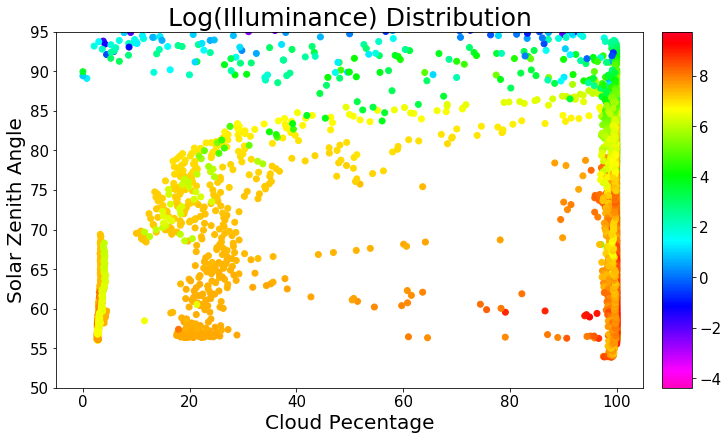

In [128]:
x = df_zenith['cloudPecentage'].values
y = df_zenith['Zenith'].values

fig, ax = plt.subplots(constrained_layout=True, figsize=(10, 6))
h = ax.scatter(x, y, c = np.log(df_zenith['Illuminance'].values), cmap="gist_rainbow_r")

ax.set_title('Log(Illuminance) Distribution', fontsize=25)
ax.set_xlabel('Cloud Pecentage',fontsize=20)
ax.set_ylabel('Solar Zenith Angle',fontsize=20)
ax.set_ylim(50,95)
fig.colorbar(h, ax=ax)

fig.savefig(dir_out+'Zenith.png')


## Prepare Data  For Training

In [130]:
print('Variable Numbers in cheap sensors: ',len(df_cheap.columns))
print('Sample Numbers: ',len(df_all))

Variable Numbers in cheap sensors:  41
Sample Numbers:  4805


# Model Start from here

In [131]:
df_cheap.columns

Index(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed', 'skyGreen',
       'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue', 'Violet', 'Blue',
       'Green', 'Yellow', 'Orange', 'Red', 'Temperature', 'Pressure',
       'Humidity', 'Latitude', 'Longitude', 'Altitude', 'NH3', 'CO', 'NO2',
       'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'c02', 'Luminosity', 'IR',
       'Full', 'Visible', 'Lux', 'UVA', 'UVB', 'Visible Compensation',
       'IR Compensation', 'UV Index'],
      dtype='object')

In [132]:
df_minolta.columns

Index(['Illuminance', '360nm', '361nm', '362nm', '363nm', '364nm', '365nm',
       '366nm', '367nm', '368nm',
       ...
       '772nm', '773nm', '774nm', '775nm', '776nm', '777nm', '778nm', '779nm',
       '780nm', 'Zenith'],
      dtype='object', length=423)

## Model for Single Wavelength Prediction

In [257]:
# train test datasets
target = '450nm' # this is for column name
target_name = target # this is for display

fn_data = dir_data + node_id + '_'+ cheap_node_id +'_by_SKYCAM.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
print('Number of Samples: ',len(df))

# remove the data at night, since cloud percantage doesn't work at night
df = df[((df.index.hour - hour_jetlag)>=6) * ((df.index.hour - hour_jetlag)<18)]
print('Number of Samples in daytime: ', len(df))

features = np.append(df.columns[:41], ['Zenith'])
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 


Number of Samples:  4805
Number of Samples in daytime:  3452


In [210]:
features

array(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed',
       'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
       'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
       'Temperature', 'Pressure', 'Humidity', 'Latitude', 'Longitude',
       'Altitude', 'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2',
       'C2H5OH', 'c02', 'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
       'UVA', 'UVB', 'Visible Compensation', 'IR Compensation',
       'UV Index', 'Zenith'], dtype=object)

In [223]:
# Random Forest Model, grid search to find best parameter
RANDOM_STATE = 42
rfr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = -1)
param_grid = {'max_depth': [10,20,30,40,50],'n_estimators': [50,100]}
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv =5, verbose = 3)

CV_rfr.fit(X_train, y_train)
print(CV_rfr.best_params_)
print(CV_rfr.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=10, n_estimators=50, score=0.893, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.898, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV] ....... max_depth=10, n_estimators=50, score=0.905, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.896, total=   0.5s
[CV] max_depth=10, n_estimators=50 ...................................
[CV] ....... max_depth=10, n_estimators=50, score=0.912, total=   0.5s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.897, total=   0.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.907, total=   0.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.908, total=   0.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ...... max_depth=10, n_estimators=100, score=0.900, total=   0.8s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   36.5s finished


{'max_depth': 30, 'n_estimators': 100}
0.9052646862919502


In [258]:
regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth=30,#CV_rfr.best_params_['max_depth'], # 30
                             n_estimators=100)#CV_rfr.best_params_['n_estimators'])#100
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [259]:
fn_model = '../models/RF_single_30_100.sav'
pickle.dump(regr, open(fn_model, 'wb'))

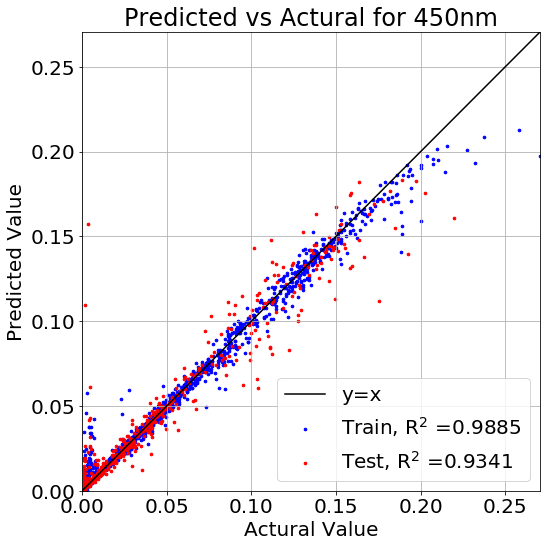

In [260]:
from sklearn.metrics import r2_score
train_score = r2_score(y_train,regr.predict(X_train))
test_score = r2_score(y_test,regr.predict(X_test))

y_line = np.linspace(np.min(y),np.max(y),100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,regr.predict(X_train), s=7, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,regr.predict(X_test), s=7, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((np.min(y),np.max(y)))
plt.ylim((np.min(y),np.max(y)))
ax.set_title('Predicted vs Actural for ' + target_name)
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig(dir_out +'performance_'+target_name+'.png')


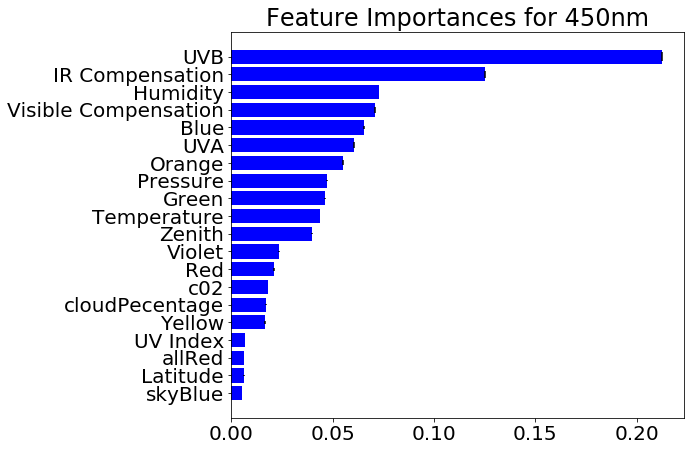

In [226]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out +'feature_imp_'+ target_name+'.png')

In [227]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
num_shap = 1000
shap_values = explainer.shap_values(X_train[:num_shap])

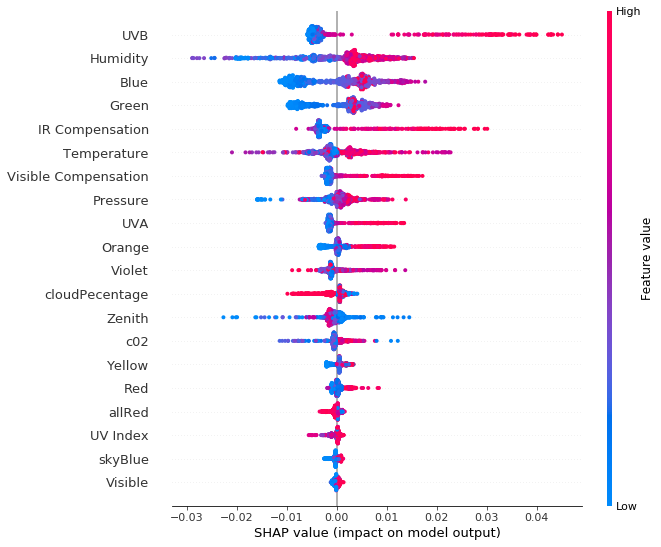

In [228]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(10,8),#'auto'
                  max_display = 20,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + 'shap_'+ target_name+'.png')

## Model for Whole Spectrum

In [235]:
# split dataset first, then expand each sample on 360-780 wavelengthes
df_train, df_test = train_test_split(df, random_state = 0, test_size=0.2)

In [236]:
start_time = time.time()

df_train_expand = []
df_test_expand = []
df_train_temp = df_train[features]
df_test_temp = df_test[features]
for i in range(360, 780+1):
    wavelength = i
    if i % 60 == 0:
        print(i)
    var = str(i)+'nm'
    df_train_add = df_train_temp.copy()
    df_test_add = df_test_temp.copy()
    
    df_train_add['Wavelength'] = i
    df_test_add['Wavelength'] = i
    
    df_train_add['Intensity'] = df_train[var]
    df_test_add['Intensity'] = df_test[var]
    
    if len(df_train_expand) == 0:
        df_train_expand = df_train_add
        df_test_expand = df_test_add
    else:
        df_train_expand = pd.concat([df_train_expand, df_train_add])
        df_test_expand = pd.concat([df_test_expand, df_test_add])

print('Number of Training Samples: ',len(df_train_expand))
print('Number of Testing Samples: ',len(df_test_expand))
print("--- %s seconds ---" % (time.time() - start_time))

360
420
480
540
600
660
720
780
Number of Training Samples:  1162381
Number of Testing Samples:  290911
--- 257.7526521682739 seconds ---


In [237]:
features_expand = df_train_expand.columns[:-1].values # the last column is intensity (target)
features_expand


array(['cloudPecentage', 'allRed', 'allGreen', 'allBlue', 'skyRed',
       'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
       'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
       'Temperature', 'Pressure', 'Humidity', 'Latitude', 'Longitude',
       'Altitude', 'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2',
       'C2H5OH', 'c02', 'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
       'UVA', 'UVB', 'Visible Compensation', 'IR Compensation',
       'UV Index', 'Zenith', 'Wavelength'], dtype=object)

In [238]:
# train test datasets
target = 'Intensity'
target_name = target

X_train = df_train_expand[features_expand]
y_train = df_train_expand[target]

X_test = df_test_expand[features_expand]
y_test = df_test_expand[target]

# use 10% of training dataset for grid search
X_train_sample, X_train_drop, y_train_sample, y_train_drop = train_test_split(X_train, y_train, test_size=0.9, random_state=0) 
print(len(X_train))
print(len(X_train_sample))


1162381
116238


In [170]:
# Random Forest Model, grid search to find best parameter
RANDOM_STATE = 42
rfr = RandomForestRegressor(random_state = RANDOM_STATE, oob_score=True, n_jobs = -1)
param_grid = {'max_depth': [20,30],'n_estimators': [50,100]}
CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv =5, verbose = 3)

CV_rfr.fit(X_train_sample, y_train_sample)
print(CV_rfr.best_params_)
print(CV_rfr.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] max_depth=20, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... max_depth=20, n_estimators=50, score=0.998, total=  16.9s
[CV] max_depth=20, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.9s remaining:    0.0s


[CV] ....... max_depth=20, n_estimators=50, score=0.998, total=  15.7s
[CV] max_depth=20, n_estimators=50 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   32.6s remaining:    0.0s


[CV] ....... max_depth=20, n_estimators=50, score=0.998, total=  15.3s
[CV] max_depth=20, n_estimators=50 ...................................
[CV] ....... max_depth=20, n_estimators=50, score=0.998, total=  15.9s
[CV] max_depth=20, n_estimators=50 ...................................
[CV] ....... max_depth=20, n_estimators=50, score=0.998, total=  16.2s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.998, total=  33.4s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.998, total=  35.2s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.998, total=  36.4s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] ...... max_depth=20, n_estimators=100, score=0.998, total=  35.4s
[CV] max_depth=20, n_estimators=100 ..................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  8.8min finished


{'max_depth': 30, 'n_estimators': 100}
0.9982467845786742


In [240]:
start_time = time.time()
regr = RandomForestRegressor(random_state = RANDOM_STATE,
                             max_depth=30,
                             n_estimators=100)
regr.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1441.3715493679047 seconds ---


In [247]:
fn_model = '../models/RF_whole_30_100.sav'
pickle.dump(regr, open(fn_model, 'wb'))

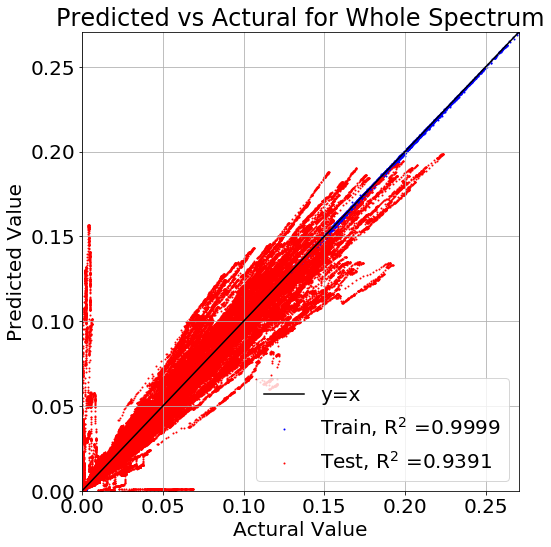

In [241]:
from sklearn.metrics import r2_score
train_score = r2_score(y_train,regr.predict(X_train))
test_score = r2_score(y_test,regr.predict(X_test))

y_line = np.linspace(np.min(y),np.max(y),100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,regr.predict(X_train), s=1, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,regr.predict(X_test), s=1, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((np.min(y),np.max(y)))
plt.ylim((np.min(y),np.max(y)))
ax.set_title('Predicted vs Actural for Whole Spectrum')
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()
plt.savefig(dir_out +'performance_whole.png')


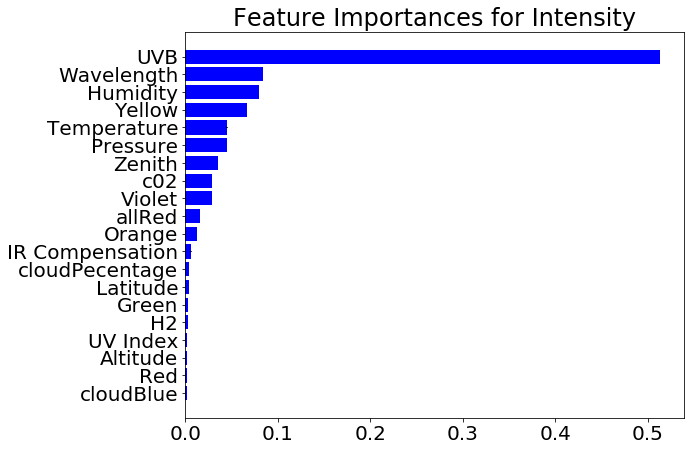

In [242]:
# rank feature inportance
num_features = 20
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

var_sorted = features_expand[indices]
var_imp_sorted = importances[indices]

plt.rcParams["figure.figsize"] = (10, num_features/3) # (w, h)
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features], var_imp_sorted[:num_features],
        yerr=std[indices][:num_features], ecolor='black',
        color = 'blue', align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Feature Importances for ' + target_name)
plt.tight_layout()
plt.savefig(dir_out +'feature_imp_whole.png')

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
num_shap = 500
shap_values = explainer.shap_values(X_train[:num_shap])

In [ ]:
# plot
shap.summary_plot(shap_values, X_train[:num_shap],
                  plot_size=(10,8),#'auto'
                  max_display = 20,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + 'shap_whole.png')

## Compare Full Spectrum with Prediction

In [78]:
year = 2019
month = 12
day = 31
hour = 11+6
jetlag = 6
date_string = '%04d-%02d-%02d %02d:00:00' % (year, month, day, hour)

In [79]:
iwant = (X.index == date_string)

In [80]:
wavelengths = np.array(range(360,780+1))

x1 = X[iwant].index.values
y1 = y[iwant].values
y1_pred = regr.predict(X[iwant])

In [81]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
spectrum = y1
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag), fontsize=40)
ax.set_xlabel('Wavelength / nm',fontsize=30)
ax.set_ylabel('Intensity',fontsize=30)

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d.png' % (year, month, day, hour-jetlag))
plt.close()

In [82]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(16, 8))
spectrum = y1_pred
h = ax.plot(wavelengths, spectrum)

plt.plot(wavelengths, spectrum)

y2 = np.linspace(0, np.max(spectrum)*1.1, 100)

XX,YY = np.meshgrid(wavelengths, y)
XX[XX<400] = 400
extent=(np.min(wavelengths), np.max(wavelengths), np.min(y2), np.max(y2))

plt.imshow(XX, clim=(350,780),  extent=extent, cmap=spectralmap, aspect='auto')
plt.fill_between(wavelengths, spectrum, np.max(spectrum)*1.1, color='w')
ax.set_title('Predicted Spectrum: %02d/%02d/%02d %02d:00' % (year, month, day, hour-jetlag), fontsize=40)
ax.set_xlabel('Wavelength / nm',fontsize=30)
ax.set_ylabel('Intensity',fontsize=30)

fig.savefig(dir_out+'Spectrum_%02d_%02d_%02d_%02d_pred.png' % (year, month, day, hour-jetlag))
plt.close()